In [1]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.stats
import io
import base64
#from IPython.core.display import display
from IPython.display import display, HTML, Image
from urllib.request import urlopen

try:
    import astropy as apy
    import astropy.table
    _apy = True
    #print('Loaded astropy')
except:
    _apy = False
    #print('Could not load astropy')

## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

## Customising the look of the notebook
display(HTML("<style>.container { width:95% !important; }</style>"))
## This custom file is adapted from https://github.com/lmarti/jupyter_custom/blob/master/custom.include
HTML('custom.css')
#HTML(urlopen('https://raw.githubusercontent.com/bretonr/intro_data_science/master/custom.css').read().decode('utf-8'))

In [14]:
## Custom imports
from scipy.stats import binom, poisson, chi2, norm, uniform
from scipy.optimize import curve_fit
from math import ceil, pi
from numpy import exp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle

In [3]:
## Adding a button to hide the Python source code
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>''')

<div class="container-fluid">
    <div class="row">
        <div class="col-md-9" align="center">
            <h1>PHYS10792: Introduction to Data Science</h1>
            <!--<h3>2019-2020 Academic Year</h3><br>-->
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-3" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.ajmarkwick.net/">Dr. Andrew Markwick</a> - Twitter <a href="https://twitter.com/AndrewMarkwick">@AndrewMarkwick</a><br>
            <a href="http://www.hep.manchester.ac.uk/u/gersabec">Prof. Marco Gersabeck</a> - Twitter <a href="https://twitter.com/MarcoGersabeck">@MarcoGersabeck</a>
        </div>
    </div>
</div>

# Chapter 7

## Syllabus

1. Probabilities and interpretations
2. Probability distributions
3. Parameter estimation
4. Maximum likelihood
5. Least square, chi2, correlations
6. Monte Carlo basics
7. **Goodness of fit tests**
8. Hypothesis testing
9. Probability and confidence level
10. Limit setting
11. Introduction to multivariate analysis techniques

## Topics

**[7 Goodness of fit tests](#7-Goodness-of-fit-tests)**

**[7.1 Introduction](#7.1-Introduction)**

**[7.2 Chi-squared test](#7.2-Chi-squared-test)**
- 7.2.1 General formulae
- 7.2.2 Application

**7.3 Comparing fit models (skipped)**

**[7.4 Two sample problem](#7.4-Two-sample-problem)**
- 7.4.1 Comparing samples with known $\sigma$

**[7.5 Kolmogorov-Smirnov test and its application to the two-sample problem](#7.5-Kolmogorov-Smirnov-test-and-its-application-to-the-two-sample-problem)**
- 7.5.1 The Kolmogorov-Smirnov test
- 7.5.2 Kolmogorov-Smirnov test with two samples

### 7.1 Introduction

Many experiments extract their results by fitting a parametrisation of the observables to the data distribution. While fits can generally be convinced to converge and thereby give an answer the question arises of how trustworthy such results are.

This section will cover different approaches for assessing the goodness of fits. The fits themselves were discussed in Chapters 4 and 5. Essentially, goodness of fit tests can be interpreted as hypothesis tests as well, which will become clear in Chapter 8, but which is not required for the understanding of this Chapter.

### 7.2 Chi-squared test

#### 7.2.1 General formulae

The formulae below are a recap from Chapter 5.

The $\chi^2$ test is the most widely used goodness of fit test. In general, for sets of $n$ measurements $x_i$ and $y_i$, where $x_i$ is known precisely and $y_i$ is measured with uncertainty $\sigma_i$, the $\chi^2$ value is defined for the fit function $f(x_i)$ as

$$\chi^2=\sum_{i=1}^n\frac{(y_i-f(x_i))^2}{\sigma_i^2}.$$

This function you should be able to recall. The $\chi^2$ function shows that each measurement will contribute roughly $1$ to the total $\chi^2$ assuming that the measured values fluctuate around the function values with a spread corresponding to their $\sigma$. Hence, $\chi^2$ is expected to take a value of roughly $n$; however, we will discuss this more accurately below.

More generally, one can write the $\chi^2$ formula as a matrix equation, which includes correlations between measurements, as

$$\chi^2=({\bf y}-{\bf f})^{\rm T}{\bf V}^{-1}({\bf y}-{\bf f}),$$

where ${\bf V}$ is the covariance matrix of the measurements, but we will not need this within this lecture course.

The probability distribution for $\chi^2$ is given by

$$P(\chi^2;N)=\frac{2^{-N/2}}{\Gamma(N/2)}\chi^{N-2}e^{-\chi^2/2},$$

where $N$ is the number of degrees of freedom. These are in principle the number of measurements $n$, but they are reduced by each of the free parameters of the fit function $k$, such that $N=n-k$. This is because each of the fit parameters is optimised to minimise the $\chi^2$ during the fitting process. If any of the function parameters are not fitted but rather fixed to a specific value, the number of degrees of freedom should _not_ be reduced for these fixed parameters.

This can be used to calculate the $\chi^2$ probability, which is the probability of a random value of the $\chi^2$ distribution taking a value greater than a specified threshold.

$${\rm Prob}(\chi^2;N)=\int_{\chi^2}^{\infty}P(\chi'^2;N)d\chi'^2.$$

One interpretation is, if you conduct a large number of fits with an appropriate model to independent datasets, each with $N$ degrees of freedom, then the $\chi^2$ probability corresponds to the fraction of fits that result in a $\chi^2$ value greater than the threshold.

Let's have a look at it:

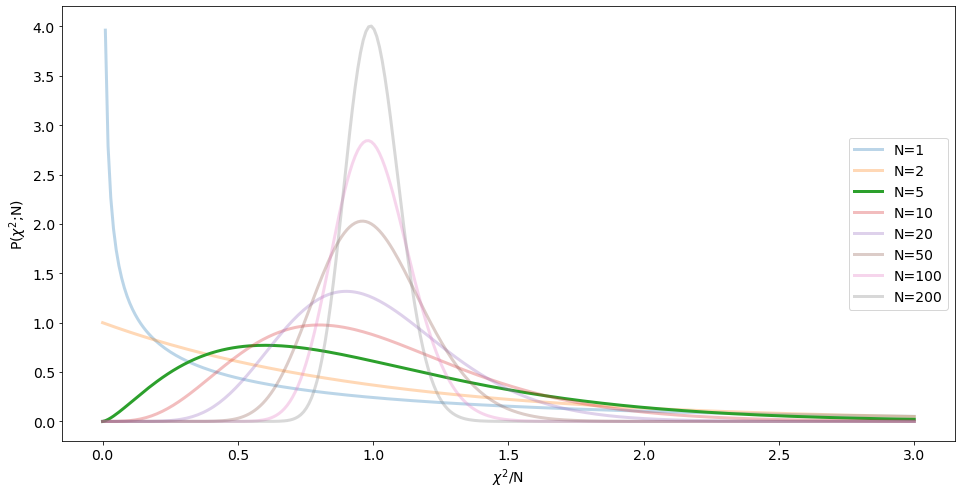

In [4]:
x = np.linspace(0, 3, 300)
fig,ax = plt.subplots(figsize=(16, 8))
ndfs=[1,2,5,10,20,50,100,200]
for df,c in zip(ndfs,plt.get_cmap('tab10').colors):
    xdf = x*df
    if df != 5:
        ax.plot(x, chi2.pdf(xdf, df)*df,'r-', color=c, lw=3, alpha=0.3, label='N='+str(df))
    else:
        ax.plot(x, chi2.pdf(xdf, df)*df,'r-', color=c, lw=3, alpha=1., label='N='+str(df))
ax.legend(loc=5)
ax.set_xlabel('$\chi^2$/N')
ax.set_ylabel('P($\chi^2$;N)')
plt.show()

This plot shows $\chi^2$ probability density functions for various degrees of freedom (N). For ease of comparison the $x$ axis has been scaled by N.

We can see that the mean indeed is approximately the number of degrees of freedom. However, the variance of the distribution differs strongly with N.

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$



#### 7.2.2 Application

One often comes across statements like "$\chi^2/N<1.5$ indicates a good fit". This is rather pointless as the significance of this statement varies strongly with N. The following shows the probabilities of a fluctuation of the $\chi^2$ test exceeding this threshold for different degrees of freedom.

In [5]:
print('{0:3} {1:8}'.format('  N','Prob chi2>1.5N'))
limits = [1.5*n for n in ndfs]
for n,p in zip(ndfs,chi2.cdf(limits, ndfs)):
    print('{0:3d} {1:8f}'.format(n,1-p))

  N Prob chi2>1.5N
  1 0.220671
  2 0.223130
  5 0.186030
 10 0.132062
 20 0.069854
 50 0.012597
100 0.000904
200 0.000006


So rather than fixing a useless limit in $\chi^2/N$, we should fix the desired significance and deduce the corresponding acceptable limit in $\chi^2$ (or $\chi^2/N$). So let's have a look how this pans out for a limit of $1\%$. This means that the integral of the $\chi^2$ distribution for a given value of $N$ from $0$ to the upper limit quoted below is equal to $1 - 0.01 = 0.99$.

In [6]:
print('{0:3} {1:8}'.format('  N','max. chi^2/N'))
for n,p in zip(ndfs,chi2.ppf(0.99, ndfs)):
    print('{0:3d} {1:8f}'.format(n,p/n))

  N max. chi^2/N
  1 6.634897
  2 4.605170
  5 3.017254
 10 2.320925
 20 1.878312
 50 1.523078
100 1.358067
200 1.247226


##### Example: fit to un-binned dataset

Having worked out how to set an acceptance threshold we can now have a look at how this applies to a concrete dataset.

In the example below we have data points randomly distributed between 0 and 1 with $y$ values that are randomly distributed around 1. As a fit function we use a parabola. As this function has 3 parameters, we use as the number of degrees of freedom the number of measurement points minus 3.

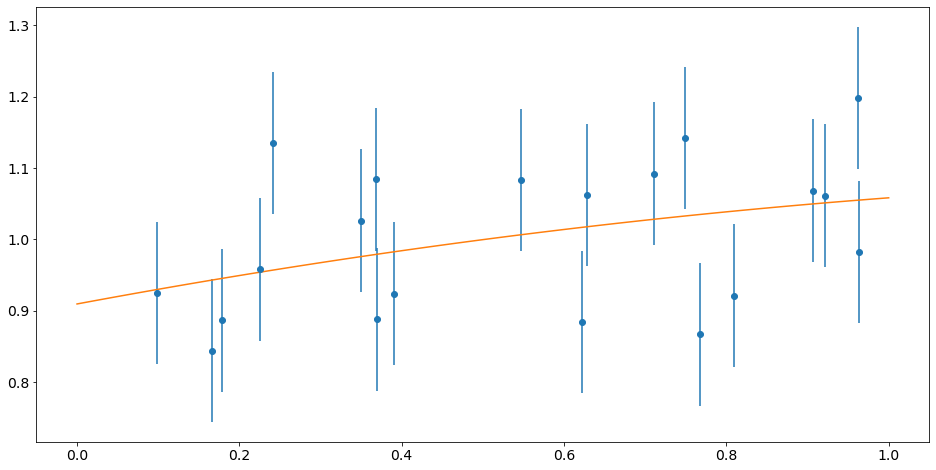

Fit function: [0]-[1]*(x-[2])^2
Fit results:
Par. 0: 1.08742 +/- 0.45309
Par. 1: 0.06302 +/- 0.36848
Par. 2: 1.68061 +/- 6.65558
The fit chi2 is 18.0 for 20 measurements and 3 fit parameters, i.e. 17 degrees of freedom.
The corresponding probability is Prob(18.0,17)=38.62635%.


In [7]:
def fitf(x,a,b,c):
    # Par a: Minimum height
    # Par b: Parabola width
    # Par c: Minimum position
    return a-b*(x-c)**2

# measurement
sigma = 0.1
nmeas = 20
xx = uniform.rvs(size=nmeas)
yy = [1+x for x in norm.rvs(scale=sigma,size=nmeas)]

# fitting
popt, pcov = curve_fit(fitf, xx, yy)

# get values to plot
fx = [x/100. for x in range(101)]
fy = [fitf(x,popt[0],popt[1],popt[2]) for x in fx]

# chi2 calculation
c2 = 0
for x,y in zip(xx,yy):
    c2 += ((y-fitf(x,popt[0],popt[1],popt[2]))/sigma)**2

# plotting
fig,ax = plt.subplots(figsize=(16, 8))
ax.errorbar(xx, yy, yerr=[sigma]*nmeas, fmt='o')
ax.plot(fx,fy)
plt.show()

# printing output
print('Fit function: [0]-[1]*(x-[2])^2')
print('Fit results:')
for p in range(3):
    print('Par. {0}: {1:.5f} +/- {2:.5f}'.format(p,popt[p],pcov[p][p]**0.5))
print('The fit chi2 is {0:3.1f} for {1} measurements and 3 fit parameters, i.e. {2} degrees of freedom.'.format(c2,nmeas,nmeas-3))
print('The corresponding probability is Prob({0:.1f},{1})={2:.5f}%.'.format(c2,nmeas-3,100*(1-chi2.cdf(c2,nmeas-3))))

##### Example: fit to binned dataset

In principle things are very similar for a binned dataset, i.e. when the fitted data are represented in a histogram. The main difference is that the number of degrees of freedom is no longer given by the number of elements in the dataset but rather by the number of bins of the histogram. The reduction by the number of fit parameters is unchanged.

A second difference is the uncertainty used in the $\chi^2$ calculation. This is no longer the uncertainty of the individual entries contributing to the histogram, but the uncertainty on the cumulative content of each bin. For a counting experiment with sufficiently many counts the uncertainty would be the square root of the number of counts in each bin.

So let's have a look how this pans out in an example. We generate a dataset that is drawn from a normal distribution and fit this with a Gaussian function.

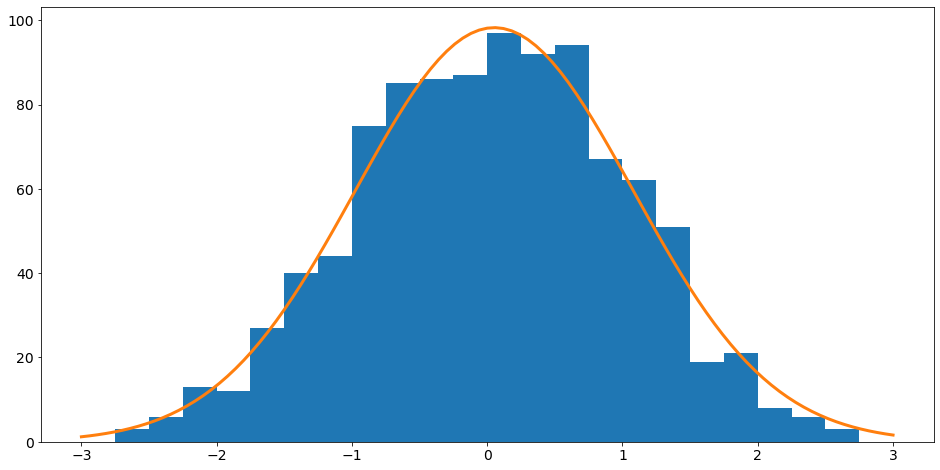

Fit function: [0]/(sqrt(2pi)*[2])*exp(-0.5*(x-[1])^2/[2]^2)
Fit results:
Par. 0: 252.96239 +/- 6.78124
Par. 1: 0.05227 +/- 0.03177
Par. 2: 1.02726 +/- 0.03185
The fit chi2 is 20.7 for 24 bins and 3 fit parameters,i.e. 21 degrees of freedom.
The corresponding probability is Prob(20.7,21)=48.02226%.


In [8]:
def fitf(x,n,m,s):
    return n/(2*pi)**0.5/s*exp(-(x-m)**2/2/s**2)

# generate data
dd = norm.rvs(size=1000)

# plot data and store in histogram
nbins = 24
xmin = -3
xmax = 3
fig,ax = plt.subplots(1,1,figsize=(16, 8))
hist,edges,patches = plt.hist(dd,bins=nbins,range=(xmin,xmax))
binw = edges[1]-edges[0]
bincentres = [x+0.5*binw for x in edges[:-1]]

popt,pcov = curve_fit(fitf,bincentres,hist)

# chi2 calculation
c2 = 0
for x,y in zip(bincentres,hist):
    if 0 < y:
        c2 += ((y-fitf(x,popt[0],popt[1],popt[2]))/y**0.5)**2

# get values to plot
fx = [xmin+(xmax-xmin)*x/100. for x in range(101)]
fy = [fitf(x,popt[0],popt[1],popt[2]) for x in fx]
ax.plot(fx,fy,lw=3)
    
plt.show()

# print output
print('Fit function: [0]/(sqrt(2pi)*[2])*exp(-0.5*(x-[1])^2/[2]^2)')
print('Fit results:')
for p in range(3):
    print('Par. {0}: {1:.5f} +/- {2:.5f}'.format(p,popt[p],pcov[p][p]**0.5))
print('The fit chi2 is {0:3.1f} for {1} bins and 3 fit parameters,i.e. {2} degrees of freedom.'.format(c2,nbins,nbins-3))
print('The corresponding probability is Prob({0:.1f},{1})={2:.5f}%.'.format(c2,nbins-3,100*(1-chi2.cdf(c2,nbins-3))))


As we know the expected shape we can also fix the parameters of the function and test the agreement of this with the data. In this case the number of degrees of freedom is not reduced by the number of parameters.

In [9]:
# chi2 calculation
c2 = 0
for x,y in zip(bincentres,hist):
    if 0 < y:
        c2 += ((y-fitf(x,250,0,1))/y**0.5)**2

# print output
print('The fit chi2 is {0:3.1f} for {1} bins,i.e. {1} degrees of freedom.'.format(c2,nbins))
print('The corresponding probability is Prob({0:.1f},{1})={2:.5f}%.'.format(c2,nbins,100*(1-chi2.cdf(c2,nbins))))

The fit chi2 is 18.0 for 24 bins,i.e. 24 degrees of freedom.
The corresponding probability is Prob(18.0,24)=80.52836%.


$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$



### 7.4 Two-sample problem

We often encounter situations where, rather than comparing a dataset to a fit curve, we need to compare two datasets. The questions asked can vary, from the comparison of a single parameter describing an aspect of their shape, e.g. mean or width, to a general comparison of whether two distributions agree with being drawn from a single parent distribution. 

#### 7.4.1 Comparing samples with known $\sigma$

One encounters quite frequently the scenario that two measurement outcomes have to be compared and checked whether they are compatible with each other. Let us assume here that the uncertainty of the measurements is known. 

You measure results $x_1$ and $x_2$ and want to compare whether they are compatible. Their resolutions are $\sigma_1$ and $\sigma_2$.

This is equivalent to testing whether their difference, 

$$x_1-x_2,$$ 

is compatible with zero.

The variance of the difference is

$$V_{12} = \sigma_1^2 + \sigma_2^2,$$

so essetially we want to compare the difference, $x_1-x_2$, to the combined uncertainty $\sigma_{12} = \sqrt{V_{12}}$.

#### Example 1: Two measurements with different known resolution

Suppose you conduct a lab experiment in pairs and you and your partner apply different methods to measure the same quantity.

As an example, let's assume you measure the height of a building. One method is a free-fall experiment where you drop a stone down the side of the building (with all necessary safety precautions) and measure the time it takes to reach the bottom. The second method is triangulation from a point nearby.

The first method yields a height of $(25.4\pm0.4)$m, and the second $(24.0\pm0.3)$m.

The difference of the measurements is $1.4$m and the combined uncertainty is $0.5$m, so the discrepancy is at the level of $2.8$ standard deviations. This corresponds to a confidence level of $99.49\%$ (see e.g. Barlow Table 3.2 or the calculation below).

In [11]:
# norm.cdf(sigma) returns the integral of a normal distribution from -infinity to sigma
# here we want the integral from -sigma to +sigma
print("{0:.2f}%".format( 100 * ( 1 - ( 1 - norm.cdf(2.8) ) * 2 ) ) )

99.49%


### 7.5 Kolmogorov-Smirnov test and its application to the two-sample problem

#### 7.5.1 The Kolmogorov-Smirnov test

The Kolmogorov-Smirnov (KS) test is used for comparing a distribution of data events to a given distribution. This distribution needs to be fully defined rather than fitted to the data as the KS test has no means of taking into account the reduction in the number of degrees of freedom.

The KS test is based on constructing cumulative distributions both of your data, ${\rm cum}(x)$, and of the function to be compared to the data, ${\rm cum}(P)$,. Both should be normalised such that the cumulative distributions go from 0 to 1. You then need to find the largest difference between the two cumulative distributions, i.e.

$$D=max|{\rm cum}(x)-{\rm cum}(P)|.$$

Finally, we need to account for the sample size as this drives the agreement of the two distributions. Hence, we scale $D$ and introduce

$$d = D \sqrt{N}.$$

The value of $d$ then needs to be compared to a table of critical values, $c$, to determine the level, $\alpha$, beyond which the statement that both distributions are compatible is rejected, i.e. you require $d<c(\alpha)$.

| &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $c(\alpha)$ | &nbsp; $\alpha$ &nbsp; |
|------|------|
| 1.63 | 0.01 |
| 1.36 | 0.05 |
| 1.22 | 0.10 |
| 1.07 | 0.20 |

##### Example

We can now apply this to a dataset. Let's choose 20 $x$ values according to a uniform distribution, similar to those used in the example above. They should be drawn from a uniform distribution between 0 and 1, so the cumulative distribution, ${\rm cum}(P)$, is a straight line. The cumulative distribution of the data, ${\rm cum}(x)$, is a step function that increases by $1/N$ at the position of each data point, where $N$ is the total number of data points in the set.

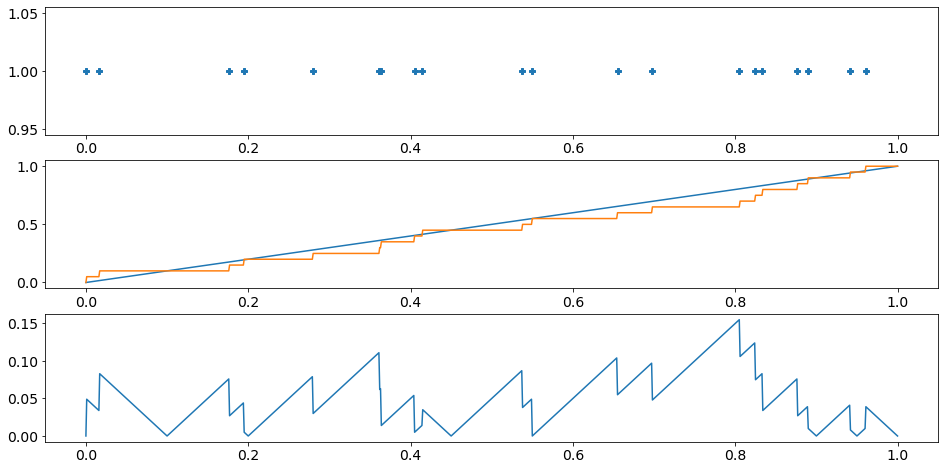

The KS test output for 20 entries is D=0.155 and d=0.693.


In [12]:
# x axis points for plotting and evaluation of the difference
xKS = [x/1000. for x in range(1001)]

# cum(P), in this case the same as x
fKS = xKS

# sort the data and build cumulative distribution on the set of x axis points
nmeas=20
xx = uniform.rvs(size=nmeas)
xx.sort()
inc = 1./len(xx)
cumX = 0
n = 0
cKS = []
for x in xx:
    while x > xKS[n]:
        cKS.append(cumX)
        n+=1
    cumX += inc
for nn in range(1001-len(cKS)):
    cKS.append(cumX)

# calculate difference dataset, the maximum of which is the KS test statistic
dKS = [abs(x-y) for x,y in zip(fKS,cKS)]

# plotting
fig,ax = plt.subplots(3,1,figsize=(16, 8))
ax[0].plot(xx, [1]*len(xx), 'P')
ax[1].plot(xKS,fKS)
ax[1].plot(xKS,cKS)
ax[2].plot(xKS,dKS)
ax[0].set_xlim(ax[1].get_xlim())
plt.show()

# print output
print('The KS test output for {0} entries is D={1:.3f} and d={2:.3f}.'.format(len(xx),max(dKS),max(dKS)*len(xx)**0.5))

#### 7.5.2 The Kolmogorov-Smirnov test with two samples

The KS test can also be applied to the two-sample problem. Instead of comparing a distribution of discrete events with a continuous distribution one can also compare two discrete distributions.

In this case one creates two staircase-like cumulative distributions, ${\rm cum}(x)$ and ${\rm cum}(y)$, that cover the two samples of $N_x$ and $N_y$ events. Once more, we need to find the largest difference between these distributions, 

$$D={\rm max}|{\rm cum}(x)-{\rm cum}(y)|.$$

In this case, the appropriate scaling is achieved by

$$d=\sqrt{\frac{N_xN_y}{N_x+N_y}}D.$$

The critical values are the same as those given before and are repeated here for convenience.


| &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; $c(\alpha)$ | &nbsp; $\alpha$ &nbsp; |
|-----|-----|
|  1.63 | 0.01 |
|  1.36 | 0.05 |
|  1.22 | 0.10 |
|  1.07 | 0.20 |

The following example compares two distributions that are drawn from a Gaussian distribution with $\mu=0.5$, $\sigma=0.1$, and $N_x=20$, $N_y=300$.

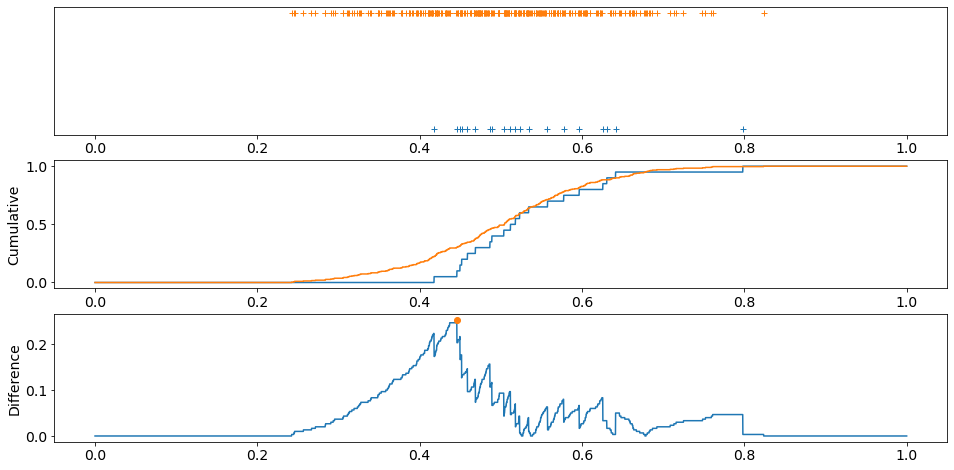

The KS test output for 20 and 300 entries is D=0.253 and d=1.097.


In [13]:
# measurement
mu = 0.5
sigma = 0.1
nmeas = 20
offset = 0.0
xx1 = norm.rvs(loc = mu+offset, scale = sigma, size=nmeas)
xx2 = norm.rvs(loc = mu, scale = sigma, size=nmeas*15)
yy1 = [1]*(nmeas)
yy2 = [2]*(nmeas*15)

# x axis points for plotting and evaluation of the difference
nSamples = 10000
xKS = [1.*x/nSamples for x in range(nSamples+1)]

def getCumX(xx,xKS):
    # sort the data and build cumulative distribution on the set of x axis points
    xx.sort()
    inc = 1./len(xx)
    cumX = 0
    n = 0
    cKS = []
    for x in xx:
        while x > xKS[n]:
            #print(n,cumX)
            cKS.append(cumX)
            n+=1
        cumX += inc
    for nn in range(nSamples+1-len(cKS)):
        cKS.append(cumX)
    return cKS

cKS1 = getCumX(xx1,xKS)
cKS2 = getCumX(xx2,xKS)

# calculate difference dataset, the maximum of which is the KS test statistic
dKS = [abs(x-y) for x,y in zip(cKS1,cKS2)]

# plotting
fig,ax = plt.subplots(3,1,figsize=(16, 8))
ax[0].plot(xx1, yy1, '+')
ax[0].plot(xx2, yy2, '+')
ax[1].plot(xKS,cKS1)
ax[1].plot(xKS,cKS2)
ax[2].plot(xKS,dKS)
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_yticks([])
ax[1].set_ylabel('Cumulative')
ax[2].set_ylabel('Difference')
y,x=max(zip(dKS,xKS))
ax[2].plot(x,y, 'o')

plt.show()

# print output
n1 = len(xx1)
n2 = len(xx2)
print('The KS test output for {0} and {1} entries is D={2:.3f} and d={3:.3f}.'.format(n1,n2,max(dKS),max(dKS)*(n1*n2/(n1+n2))**0.5))

<div class="well" align="center">
    <div class="container-fluid">
        <div class="row">
            <div class="col-md-3" align="center">
                <img align="center" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" width="60%">
            </div>
            <div class="col-md-8">
            This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>).
            </div>
        </div>
    </div>
    <br>
    <br>
    <i>Note: The content of this Jupyter Notebook is provided for educational purposes only.</i>
</div>